# Text Summarizer using BART

### Importing all the prerequisite libraries

In [94]:
import os
import time
import glob
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import math

from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
from transformers import BitsAndBytesConfig
from transformers import BartTokenizer, BartModel, BartForConditionalGeneration

import json


from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import AdamW

from tqdm.auto import tqdm

# Loading the evaluator

In [49]:
import evaluate

rouge_scorer = evaluate.load('rouge')

# Load the dataset

In [50]:
from datasets import load_dataset
from torch.utils.data import DataLoader

working_dir = os.getcwd()

# article_path, summaries_path, categories_list, filename_, categories_list = [], [], [], [], []
articles_path = os.path.join(working_dir, "BBC News Summary", "News Articles")
summaries_path = os.path.join(working_dir, "BBC News Summary", "Summaries")
categories_list = ['sport', 'entertainment', 'politics', 'business', 'tech']


# # dataset = pd.read_csv("training_corpus.csv")
# # test_dataset = pd.read_csv("assignments/6595203.csv")


# class TrainDataset(torch.utils.data.Dataset):
#     # longest first for batch finder
#     def __init__(self, dataset, split):
#         input_x = dataset['context']
#         target = dataset['target']
#         self.input_x = input_x
#         self.target = target
#         self.split = split
#         assert len(input_x) == len(target) # test if the condition is true
#     def __getitem__(self, idx):
#         ### Your code here
#         input = self.input_x[idx]
#         target = self.target[idx]
#         return{
#             'input': input,
#             'target': target,
#             'split': self.split,
#         }
#     def __len__(self):
#         ### Your code here
#         return len(self.input_x)

# class TestDataset(torch.utils.data.Dataset):
#     # longest first for batch finder
#     def __init__(self, dataset, split):
#         input_x = dataset['context']
#         self.input_x = input_x
#         self.split = split

#     def __getitem__(self, idx):
#         input = self.input_x[idx]
#         return{
#             'input': input,
#             'split': self.split,
#         }
#     def __len__(self):
#         return len(self.input_x)
    


# train_dataset = TrainDataset(dataset['context'][:1000], 'train')
# test_dataset = TestDataset(dataset['context'][:100], 'test')
# train_dataset = TrainDataset(dataset, 'train')
# test_dataset = TestDataset(dataset, 'test')
# train_dataset = TrainDataset(dataset, 'train')
# test_dataset = TestDataset(test_dataset, 'test')



In [51]:
def read_files(articles_path, summaries_path, categories_list=['sport', 'entertainment', 'politics', 'business', 'tech'], encoding = "ISO-8859-1"):
  articles=[]
  summaries=[]
  categories = []
  for category in categories_list:
    article_paths = glob.glob(os.path.join(articles_path, category, '*.txt'), recursive=True)
    print(f"this is article paths: {article_paths}")
    summary_paths = glob.glob(os.path.join(summaries_path, category, '*.txt'), recursive=True)

    print(f'found {len(article_paths)} file in articles/{category} folder, {len(summary_paths)} file in summaries/{category}' )

    if len(article_paths) != len(summary_paths):
      print('number of files is not equal')
      return

    #check if each article has a summary
    for idx_file in range(len(article_paths)):
      categories.append(category)
      with open(article_paths[idx_file], mode = 'r', encoding = encoding) as file:
        articles.append(file.read())

      with open(summary_paths[idx_file], mode = 'r', encoding = encoding) as file:
        summaries.append(file.read())
  print(f'total {len(articles)} file in articles folders, {len(summaries)} file in summaries folders')
  return articles, summaries, categories


In [52]:
articles, summaries, categories = read_files(articles_path, summaries_path, categories_list)

this is article paths: ['c:\\Users\\seoeunl\\Desktop\\University of Surrey\\2023-2024\\FYP2\\BBC News Summary\\News Articles\\sport\\001.txt', 'c:\\Users\\seoeunl\\Desktop\\University of Surrey\\2023-2024\\FYP2\\BBC News Summary\\News Articles\\sport\\002.txt', 'c:\\Users\\seoeunl\\Desktop\\University of Surrey\\2023-2024\\FYP2\\BBC News Summary\\News Articles\\sport\\003.txt', 'c:\\Users\\seoeunl\\Desktop\\University of Surrey\\2023-2024\\FYP2\\BBC News Summary\\News Articles\\sport\\004.txt', 'c:\\Users\\seoeunl\\Desktop\\University of Surrey\\2023-2024\\FYP2\\BBC News Summary\\News Articles\\sport\\005.txt', 'c:\\Users\\seoeunl\\Desktop\\University of Surrey\\2023-2024\\FYP2\\BBC News Summary\\News Articles\\sport\\006.txt', 'c:\\Users\\seoeunl\\Desktop\\University of Surrey\\2023-2024\\FYP2\\BBC News Summary\\News Articles\\sport\\007.txt', 'c:\\Users\\seoeunl\\Desktop\\University of Surrey\\2023-2024\\FYP2\\BBC News Summary\\News Articles\\sport\\008.txt', 'c:\\Users\\seoeunl\\Des

In [53]:
df = pd.DataFrame({'articles':articles, 'summaries':summaries, 'categories':categories}, )
df

,articles,summaries,categories
0,Claxton hunting first major medal\n\nBritish h...,"For the first time, Claxton has only been prep...",sport
1,O'Sullivan could run in Worlds\n\nSonia O'Sull...,"The participation of O'Sullivan, currentily tr...",sport
2,Greene sets sights on world title\n\nMaurice G...,I think when I was coming up I would say there...,sport
3,IAAF launches fight against drugs\n\nThe IAAF ...,"""I am very happy to see you all, members of th...",sport
4,"Dibaba breaks 5,000m world record\n\nEthiopia'...",Ethiopia's Tirunesh Dibaba set a new world rec...,sport
...,...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,BT is introducing two initiatives to help beat...,tech
2221,Spam e-mails tempt net shoppers\n\nComputer us...,A third of them read unsolicited junk e-mail a...,tech
2222,Be careful how you code\n\nA new European dire...,This goes to the heart of the European project...,tech
2223,US cyber security chief resigns\n\nThe man mak...,Amit Yoran was director of the National Cyber ...,tech


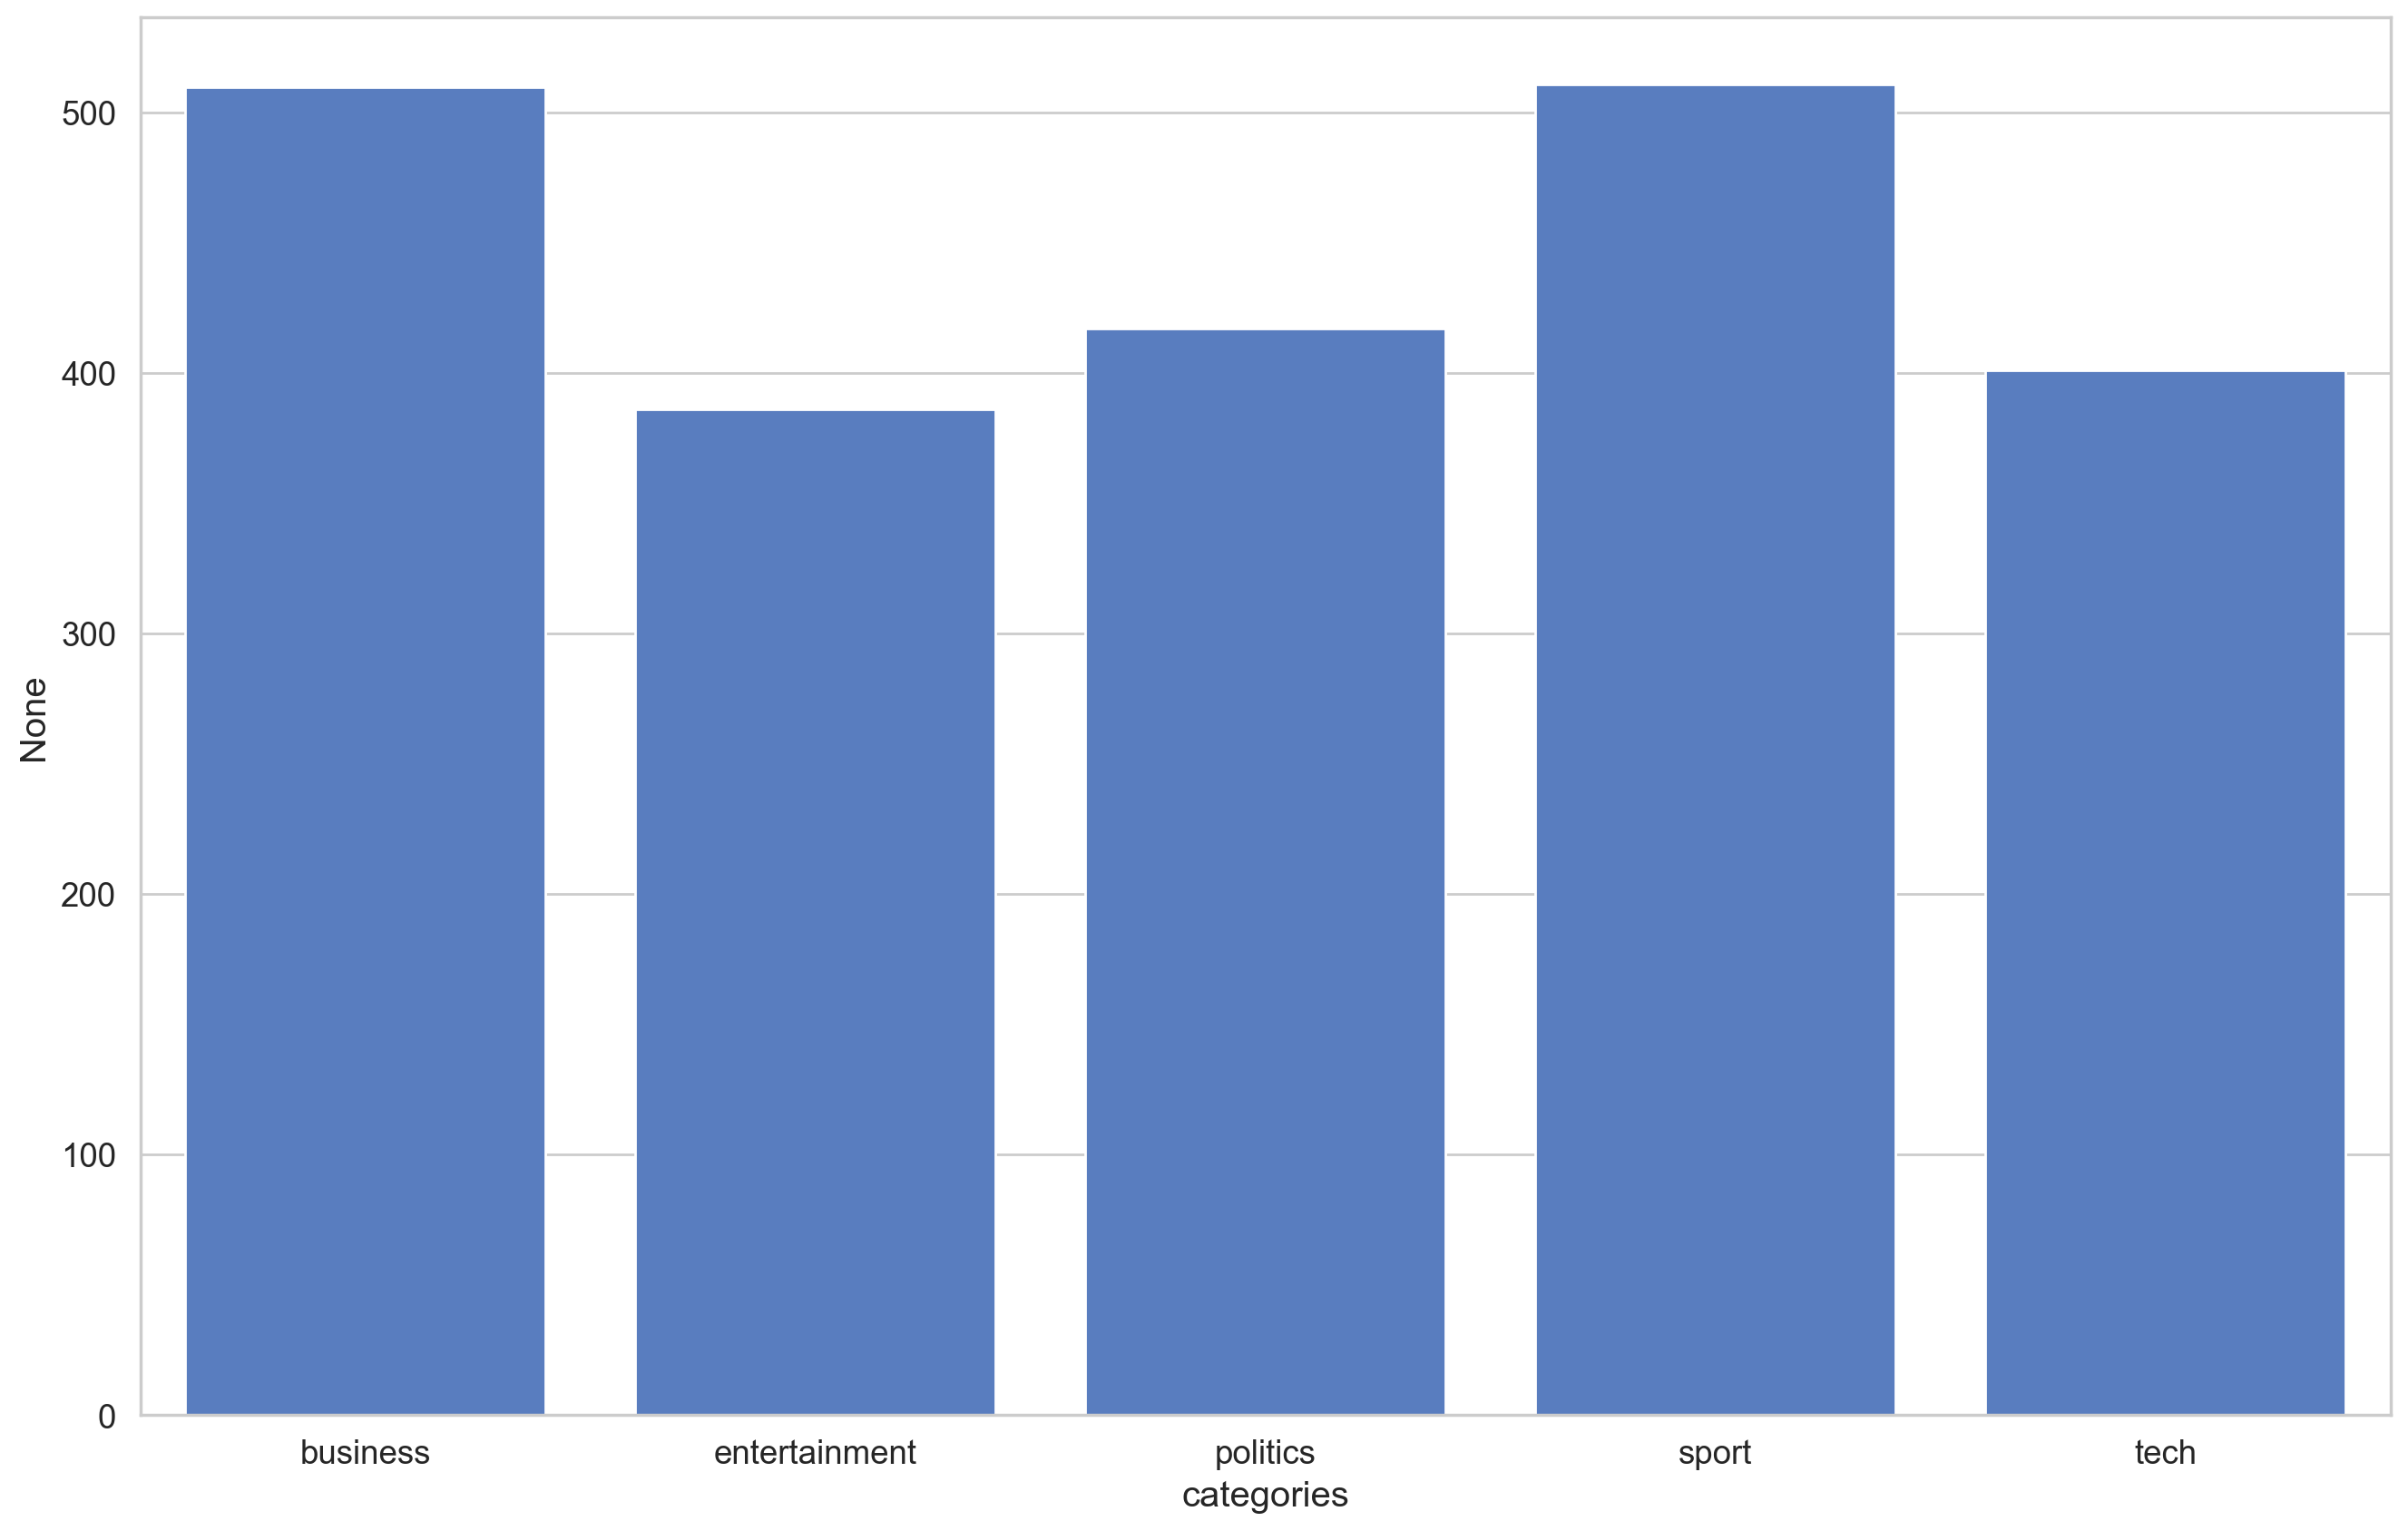

In [54]:
category_sizes = df.groupby('categories').size()
sns.barplot(x=category_sizes.index, y= category_sizes)
plt.show()

In [55]:
# get length of each article and summary for analysis
df['articles_length'] = df['articles'].apply(lambda x : len(x.split()))
df['summaries_length'] = df['summaries'].apply(lambda x : len(x.split()))

In [56]:
df

,articles,summaries,categories,articles_length,summaries_length
0,Claxton hunting first major medal\n\nBritish h...,"For the first time, Claxton has only been prep...",sport,211,91
1,O'Sullivan could run in Worlds\n\nSonia O'Sull...,"The participation of O'Sullivan, currentily tr...",sport,144,49
2,Greene sets sights on world title\n\nMaurice G...,I think when I was coming up I would say there...,sport,377,177
3,IAAF launches fight against drugs\n\nThe IAAF ...,"""I am very happy to see you all, members of th...",sport,195,99
4,"Dibaba breaks 5,000m world record\n\nEthiopia'...",Ethiopia's Tirunesh Dibaba set a new world rec...,sport,161,75
...,...,...,...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,BT is introducing two initiatives to help beat...,tech,420,186
2221,Spam e-mails tempt net shoppers\n\nComputer us...,A third of them read unsolicited junk e-mail a...,tech,357,130
2222,Be careful how you code\n\nA new European dire...,This goes to the heart of the European project...,tech,1050,475
2223,US cyber security chief resigns\n\nThe man mak...,Amit Yoran was director of the National Cyber ...,tech,379,137


In [57]:
category_length = df.groupby('categories', 0).agg({'articles_length':'mean', 'summaries_length':'mean'})
category_length

C:\Users\seoeunl\AppData\Local\Temp\ipykernel_34848\883843159.py:1: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  category_length = df.groupby('categories', 0).agg({'articles_length':'mean', 'summaries_length':'mean'})


,articles_length,summaries_length
categories,,
business,328.880392,139.929412
entertainment,330.621762,144.049223
politics,453.973621,195.709832
sport,329.262231,143.187867
tech,502.695761,213.837905


C:\Users\seoeunl\AppData\Local\Temp\ipykernel_34848\3378867931.py:2: FutureWarning: The 'axis' keyword in DataFrame.groupby is deprecated and will be removed in a future version.
  category_length = df.groupby('categories', 0).agg({'articles_length':'mean', 'summaries_length':'mean'})


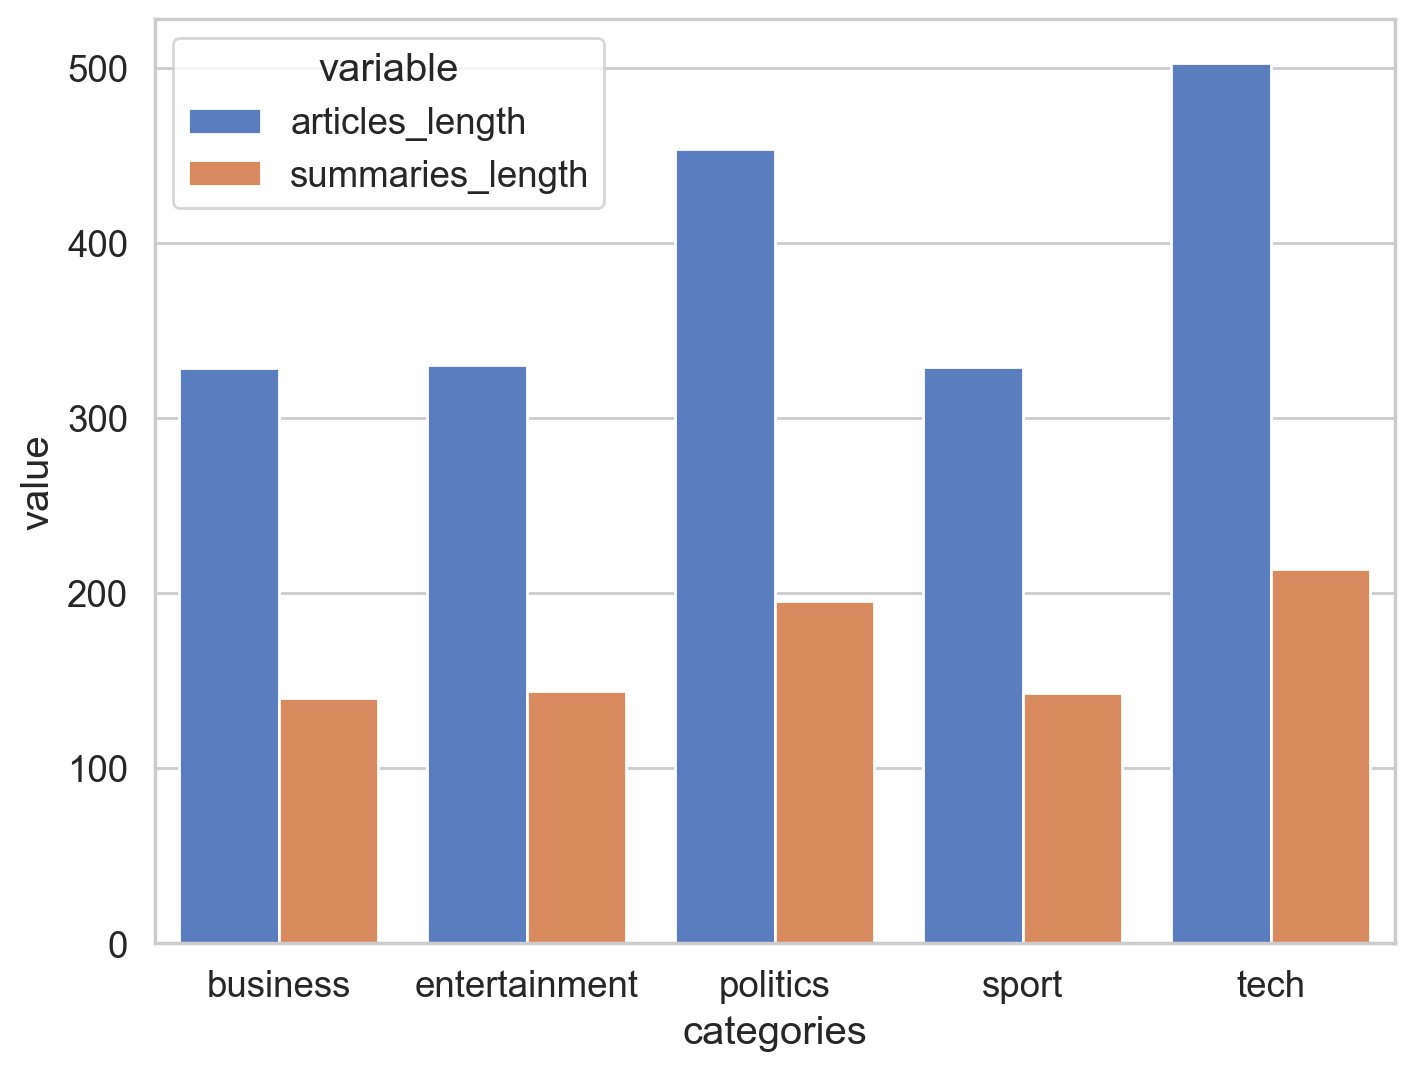

In [58]:
# graph the articles and summaries by categories
category_length = df.groupby('categories', 0).agg({'articles_length':'mean', 'summaries_length':'mean'})
df_m = pd.melt(category_length, ignore_index=False)
plt.figure(figsize=(8,6))
sns.barplot(x=df_m.index, y="value", hue="variable", data= df_m)
plt.show()

In [59]:
pd.melt(category_length, ignore_index=False).groupby('variable').mean()

,value
variable,
articles_length,389.086753
summaries_length,167.342848


In [60]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize']=16,10

In [61]:
df

,articles,summaries,categories,articles_length,summaries_length
0,Claxton hunting first major medal\n\nBritish h...,"For the first time, Claxton has only been prep...",sport,211,91
1,O'Sullivan could run in Worlds\n\nSonia O'Sull...,"The participation of O'Sullivan, currentily tr...",sport,144,49
2,Greene sets sights on world title\n\nMaurice G...,I think when I was coming up I would say there...,sport,377,177
3,IAAF launches fight against drugs\n\nThe IAAF ...,"""I am very happy to see you all, members of th...",sport,195,99
4,"Dibaba breaks 5,000m world record\n\nEthiopia'...",Ethiopia's Tirunesh Dibaba set a new world rec...,sport,161,75
...,...,...,...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,BT is introducing two initiatives to help beat...,tech,420,186
2221,Spam e-mails tempt net shoppers\n\nComputer us...,A third of them read unsolicited junk e-mail a...,tech,357,130
2222,Be careful how you code\n\nA new European dire...,This goes to the heart of the European project...,tech,1050,475
2223,US cyber security chief resigns\n\nThe man mak...,Amit Yoran was director of the National Cyber ...,tech,379,137


In [62]:
df=df[['articles','summaries']]

In [63]:
df

,articles,summaries
0,Claxton hunting first major medal\n\nBritish h...,"For the first time, Claxton has only been prep..."
1,O'Sullivan could run in Worlds\n\nSonia O'Sull...,"The participation of O'Sullivan, currentily tr..."
2,Greene sets sights on world title\n\nMaurice G...,I think when I was coming up I would say there...
3,IAAF launches fight against drugs\n\nThe IAAF ...,"""I am very happy to see you all, members of th..."
4,"Dibaba breaks 5,000m world record\n\nEthiopia'...",Ethiopia's Tirunesh Dibaba set a new world rec...
...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,BT is introducing two initiatives to help beat...
2221,Spam e-mails tempt net shoppers\n\nComputer us...,A third of them read unsolicited junk e-mail a...
2222,Be careful how you code\n\nA new European dire...,This goes to the heart of the European project...
2223,US cyber security chief resigns\n\nThe man mak...,Amit Yoran was director of the National Cyber ...


In [64]:
df=df.dropna() # remove the rows that cotain NULL values

In [65]:
df

,articles,summaries
0,Claxton hunting first major medal\n\nBritish h...,"For the first time, Claxton has only been prep..."
1,O'Sullivan could run in Worlds\n\nSonia O'Sull...,"The participation of O'Sullivan, currentily tr..."
2,Greene sets sights on world title\n\nMaurice G...,I think when I was coming up I would say there...
3,IAAF launches fight against drugs\n\nThe IAAF ...,"""I am very happy to see you all, members of th..."
4,"Dibaba breaks 5,000m world record\n\nEthiopia'...",Ethiopia's Tirunesh Dibaba set a new world rec...
...,...,...
2220,BT program to beat dialler scams\n\nBT is intr...,BT is introducing two initiatives to help beat...
2221,Spam e-mails tempt net shoppers\n\nComputer us...,A third of them read unsolicited junk e-mail a...
2222,Be careful how you code\n\nA new European dire...,This goes to the heart of the European project...
2223,US cyber security chief resigns\n\nThe man mak...,Amit Yoran was director of the National Cyber ...


In [66]:
train_df, temp_df = train_test_split(df, test_size=0.2)
val_df, test_df=train_test_split(temp_df, test_size=0.5)

In [67]:
from huggingface_hub import notebook_login

# notebook_login()

In [68]:
model_checkpoint = "facebook/bart-base"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# model = BartForConditionalGeneration.from_pretrained(model_checkpoint)


# Preprocessing the data: tokenization

In [69]:
# # Tokenizing the articles
# article_tokens=[]
# for a in df['articles']:
#     article_tokens.append(tokenizer(a))
# article_tokens


In [70]:
# # Tokenizing the summaries
# summary_tokens=[]
# for s in df['summaries']:
#     summary_tokens.append(tokenizer(s))
# summary_tokens

In [71]:
# print(f"this is the number of the articles: {len(df['articles'])}")

In [72]:
# print(f"this is the number of the summaries: {len(df['summaries'])}")

In [73]:
# print(f"this is an article: \n{df['articles'][0]}")

In [74]:
# art = [str(i) for i in df['articles'].tolist()]
# sum = [str(i) for i in df['summaries'].tolist()]
# sum[0]


In [75]:
# print(f"This is a list of articles in string format: \n{art}")
# print(f"This is a list of summaries in string format: \n{sum}")

# print(art[0])


# Preprocessing the data

In [76]:
# max_input_length = 4096
# max_target_length = 128

# def preprocess_function():
#     art = [str(i) for i in df['articles'].tolist()]
#     model_inputs = tokenizer(art)
    
#     sum = [str(i) for i in df['summaries'].tolist()]
#     labels = tokenizer(sum)

#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs


    # article_tokens=[]
    # for a in df['articles']:
    #     article_tokens.append(tokenizer(a))
    # model_inputs = article_tokens
    
    # Setup the tokenizer for targets
    # summary_tokens=[]
    # for s in df['summaries']:
    #     summary_tokens.append(tokenizer(s))
    # labels = summary_tokens

    # print("INPUT:", model_inputs[0])

# max_target_length = 128

# def preprocess_function(examples):
#     for i in range(len(df['articles'])):
#         max_input_length = len(df['articles'][i])
#         inputs = [article for article in df['articles']]
#         model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

#     # Setup the tokenizer for targets
#     labels = tokenizer(text_target=token_val, max_length=max_target_length, truncation=True)

#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs

# max_input_length = 2048
# max_target_length = 128

# def preprocess_function(examples):
#     inputs = [article for article in df['articles']]
#     model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

#     # Setup the tokenizer for targets
#     labels = tokenizer(text_target=token_val, max_length=max_target_length, truncation=True)

#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs

In [77]:
# preprocess_function()

In [78]:
# tokenized_datasets = df['articles', 'summaries'].map(preprocess_function, batched=True)

# Creating pytorch datasets and preprocessing

In [79]:
#creating pytorch dataset
class NewsSummaryDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer:AutoTokenizer, text_max_token_len: int = 512, summary_max_token_len: int = 128):
    self.tokenizer = tokenizer
    self.data = data
    self.text_max_token_len = text_max_token_len
    self.summary_max_token_len = summary_max_token_len
  def __len__(self):
    return len(self.data)

  def __getitem__(self,index: int):
    data_row = self.data.iloc[index]

    text = data_row['articles']

    text_encoding = tokenizer(
        text,
        max_length=self.text_max_token_len, #max length=512
        padding='max_length',
        truncation=True,
        return_attention_mask = True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    summary_encoding = tokenizer(
        data_row['summaries'],
        max_length=self.summary_max_token_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )

    labels = summary_encoding['input_ids']
    # Ensure we have correct labels for T5 generation
    labels[labels==0] = -100 

    return dict(
        text=text,
        summary=data_row['summaries'],
        text_input_ids=text_encoding['input_ids'].flatten(),
        text_attention_mask=text_encoding['attention_mask'].flatten(),
        labels=labels.flatten(),
        labels_attention_mask=summary_encoding['attention_mask'].flatten()
    )

In [80]:
test_df

,articles,summaries
2116,File-swappers ready new network\n\nLegal attac...,Sloncek said that currently only a Windows ver...
1189,Kilroy launches 'Veritas' party\n\nEx-BBC chat...,"""He has remarkable ability to influence people..."
1889,Kenyan school turns to handhelds\n\nAt the Mbi...,The base station processes the information fro...
1042,'Nuclear dumpsite' plan attacked\n\nPlans to a...,The government has confirmed intermediate leve...
871,Super Size Me wins writers' award\n\nSuper Siz...,Spurlock was given his award on the same day t...
...,...,...
830,Johnny Cash manager Holiff dies\n\nThe former ...,"Mr Holiff, who was also a concert promoter, ma..."
250,Bates seals takeover\n\nKen Bates has complete...,Ken Bates has completed his takeover of Leeds ...
665,Disputed Nirvana box set on sale\n\nA box set ...,"It was blocked by Courtney Love, the widow of ..."
434,Mirza shocks Kuznetsova\n\nSania Mirza continu...,"""It was such a tough first-round match and I a..."


In [81]:
class NewsSummaryDataModule(pl.LightningDataModule):
  def __init__(
      self,
      train_df: pd.DataFrame,
      test_df: pd.DataFrame,
      tokenizer: AutoTokenizer,
      batch_size: int = 0,
      text_max_token_len: int=512,
      summary_max_token_len: int=128
  ):
      super().__init__()

      self.train_df = train_df
      self.test_df = test_df
      self.batch_size = batch_size
      self.tokenizer = tokenizer
      self.text_max_token_len = text_max_token_len
      self.summary_max_token_len = summary_max_token_len

  def setup(self, stage=None):
    self.train_dataset = NewsSummaryDataset(
        self.train_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
    )
    self.test_dataset = NewsSummaryDataset(
        self.test_df,
        self.tokenizer,
        self.text_max_token_len,
        self.summary_max_token_len
    )
  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=0
    )
  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=0
    )
  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=0
    )

In [82]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
  text_token_count = len(tokenizer.encode(row['articles']))
  text_token_counts.append(text_token_count)

  summary_token_count = len(tokenizer.encode(row['summaries']))
  text_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (1080 > 1024). Running this sequence through the model will result in indexing errors


<Axes: >

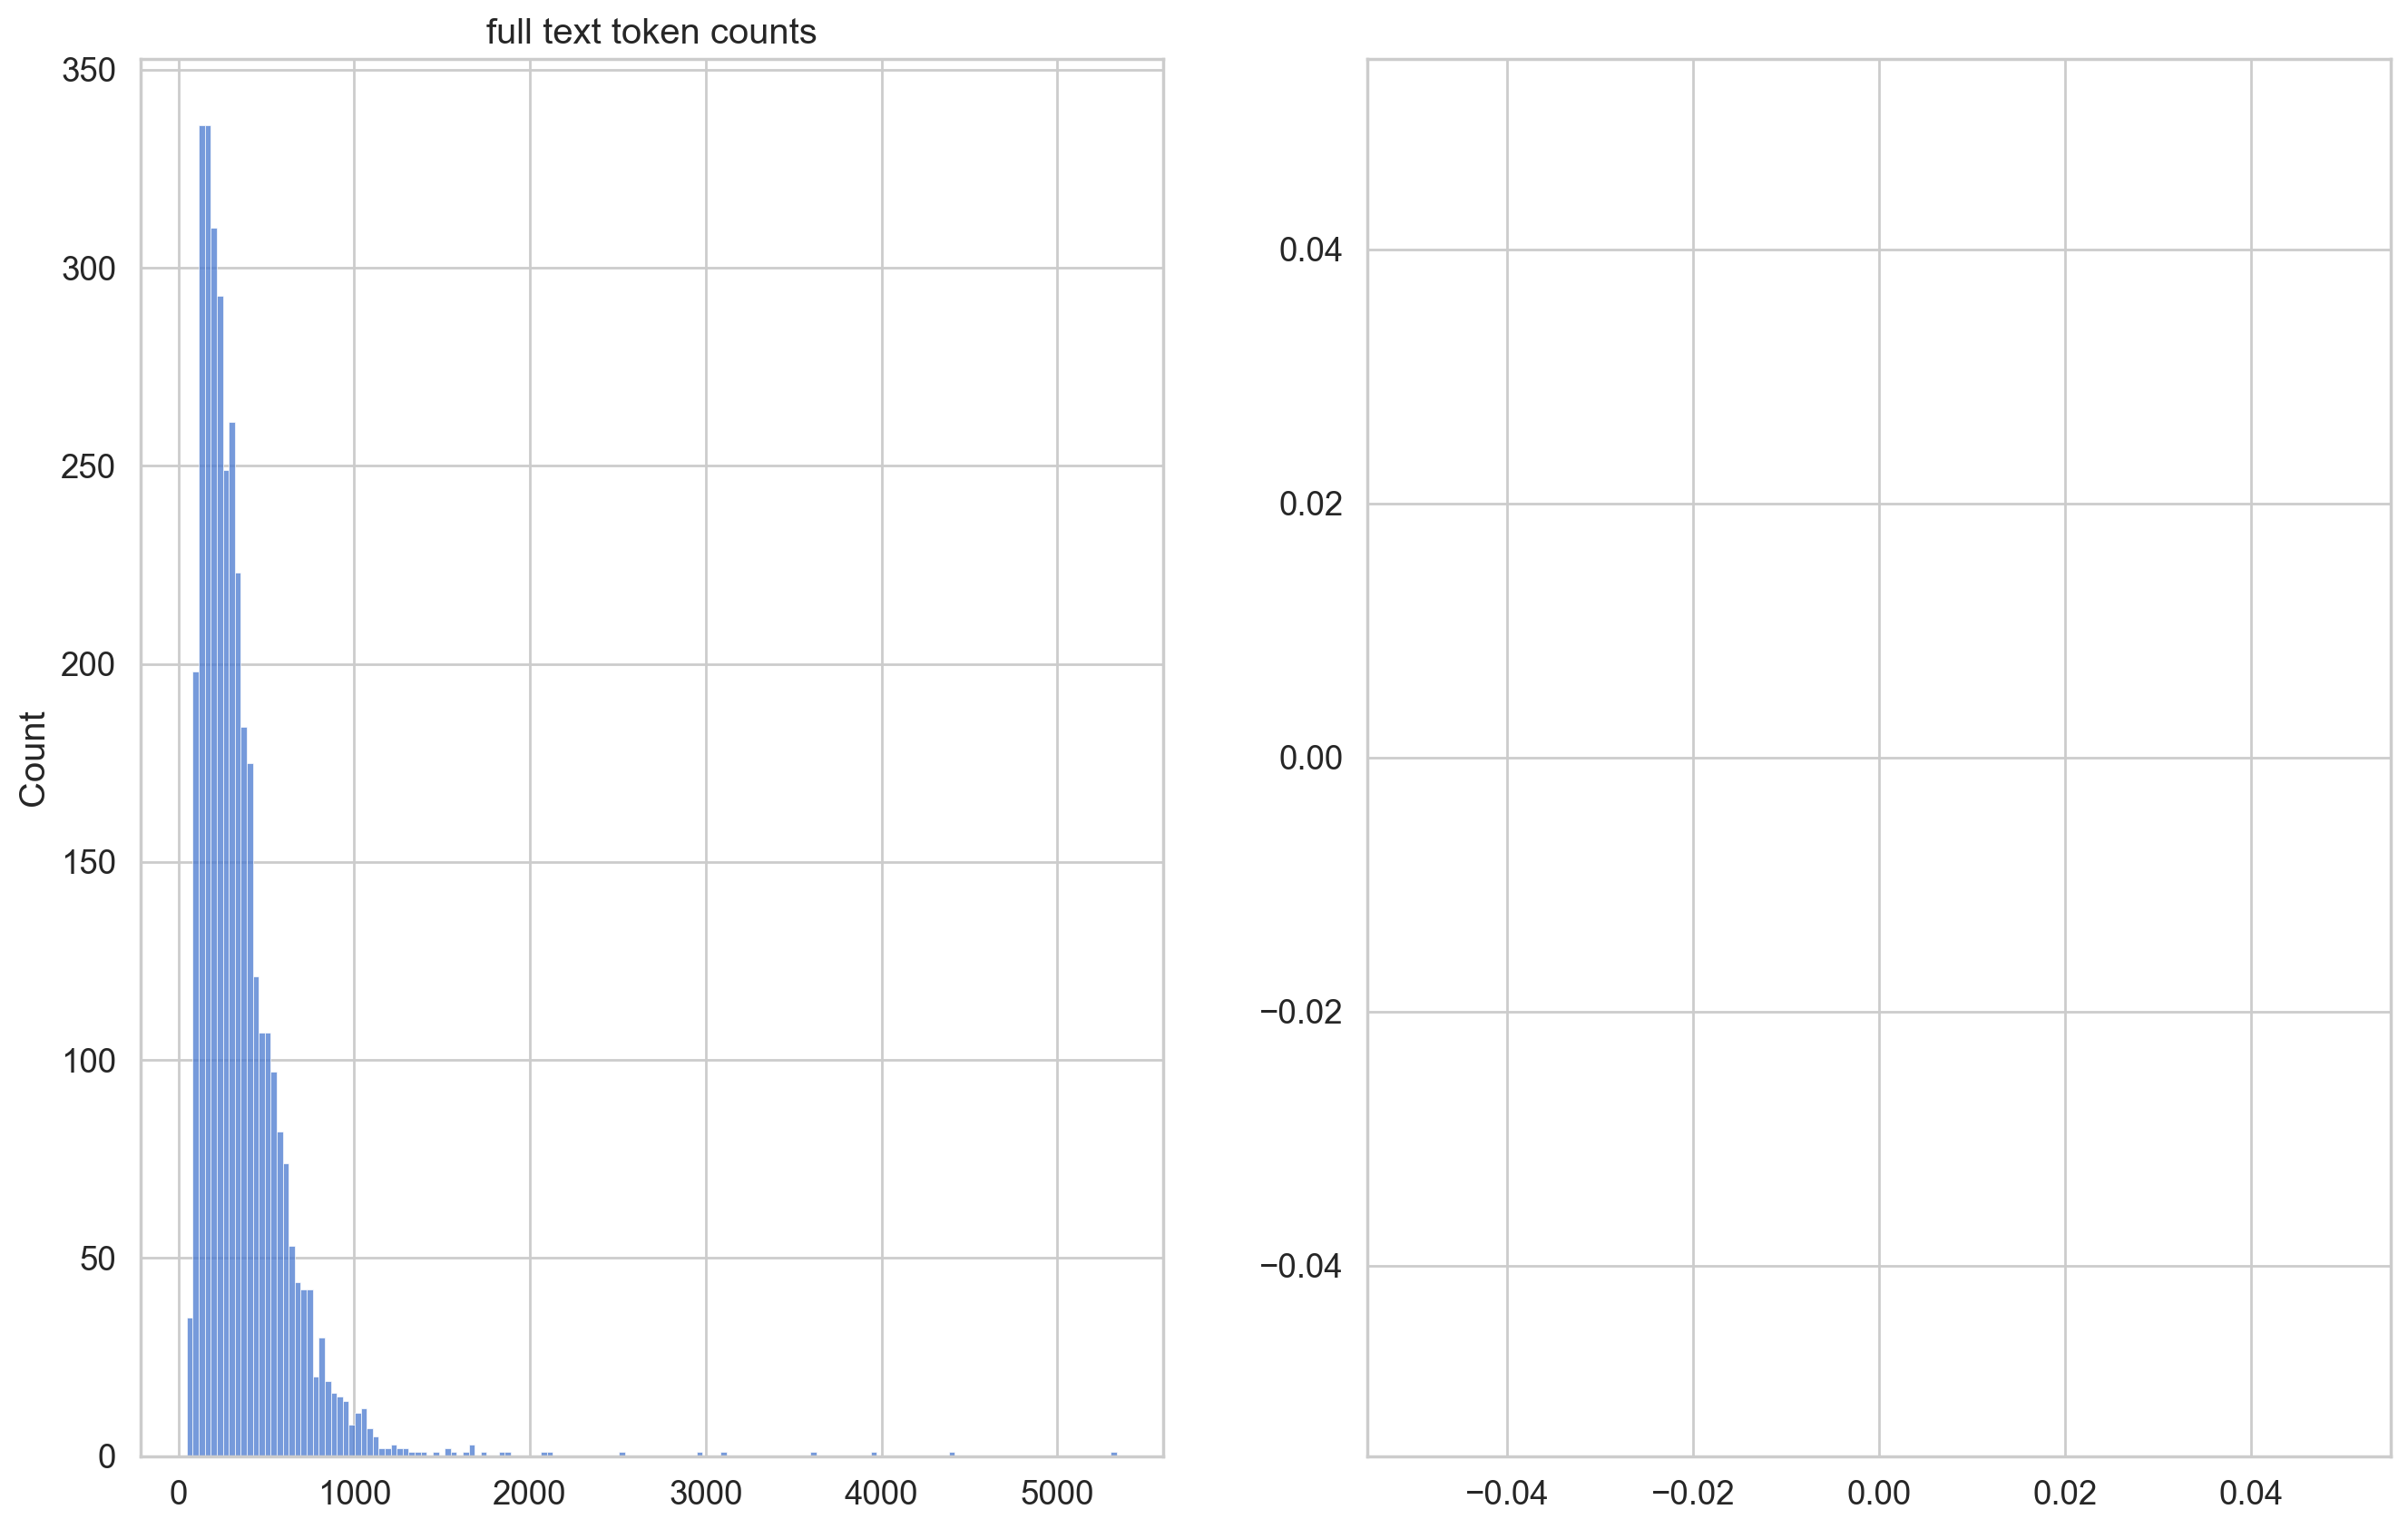

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('full text token counts')
sns.histplot(summary_token_counts, ax=ax2)

In [84]:
N_EPOCHS = 3
BATCH_SIZE = 8

data_module = NewsSummaryDataModule(train_df, test_df, tokenizer, batch_size=BATCH_SIZE)

In [85]:
data_module

# Model

In [96]:
class NewsSummaryModel(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint, return_dict=True)
  
  def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
    print("FORWARD")
    output=self.model(
        input_ids,
        attention_mask=attention_mask,
        labels=labels,
        decoder_attention_mask=decoder_attention_mask
    )
  
    return output.loss, output.logits

  def training_step(self, batch, batch_size):
    print("TRAINING")
    input_ids = batch['text_input_ids']
    attention_mask = batch['text_attention_mask']
    labels = batch['labels']
    labels_attention_mask = batch['labels_attention_mask']

    loss, outputs = self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask= labels_attention_mask,
        labels=labels
    )

    self.log("train_loss", loss, prog_bar=True, logger=True)
    return loss

  def validation_step(self, batch, batch_size):
    print("VALIDATION")
    input_ids = batch['text_input_ids']
    attention_mask = batch['text_attention_mask']
    labels = batch['labels']
    labels_attention_mask = batch['labels_attention_mask']

    loss, outputs = self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )

    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss
  def test_step(self, batch, batch_size):
    print("TEST")
    input_ids = batch['text_input_ids']
    attention_mask = batch['text_attention_mask']
    labels = batch['labels']
    labels_attention_mask = batch['labels_attention_mask']

    loss, outputs = self(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_attention_mask=labels_attention_mask,
        labels=labels
    )

    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss
  
  def configure_optimizers(self):
    return AdamW(self.parameters(), lr=0.0001)

In [97]:
model = NewsSummaryModel()

In [98]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 38352), started 1:07:22 ago. (Use '!kill 38352' to kill it.)

In [101]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger("lightning_logs", name='news-summary')

trainer = pl.Trainer(
    logger=logger,
    # checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    # gpus=1,
    # progress_bar_refresh_rate=30
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [102]:
torch.cuda.empty_cache() #clear any cache

In [103]:
import gc
gc.collect() #clear any garbage collector

7051

In [108]:
# with torch.no_grad():
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | BartForConditionalGeneration | 139 M 
-------------------------------------------------------
139 M     Trainable params
0         Non-trainable params
139 M     Total params
557.682   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

VALIDATION
FORWARD
VALIDATION
FORWARD


Training: 0it [00:00, ?it/s]

TRAINING
FORWARD


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer,checkpoint_callback.best_model_path #load the best model using checkpoint
)
trained_model.freeze()

In [ ]:
# summarize the text
def summarizeText(text):
  text_encoding = tokenizer(
      text,
      max_length=512,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors='pt'
  )

  generated_ids = trained_model.model.generate(
      input_ids=text_encoding['input_ids'],
      attention_mask = text_encoding['attention_mask'],
      max_length=150, # maximum output text length
      num_beams=2, #using beam search
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True
  )

#decoded values
  preds = [
      tokenizer.decode(gen_id,skip_special_tokens=True, clean_up_tokenization_spaces=True)
      for gen_id in generated_ids
  ]
  return "".join(preds)

In [ ]:
sample_row = test_df.iloc[0] #shows index [0] article, summary regarding the article, and its name with data type
text = sample_row['articles']
model_summary = summarizeText(text)
text

In [ ]:
sample_row['summaries'] #actual summary of the data from the dataset

In [ ]:
model_summary #model summary

In [ ]:
from evaluate import load

metric = load("rouge")

# Loading dataset

# Fine Tuning

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()